<h1>IMPORT LIBRARYS AND READ DATA<h1>


In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "colab"
import warnings
warnings.filterwarnings("ignore")

In [2]:
vic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/VIC.csv")
msn = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSN.csv")
pnj = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PNJ.csv")
fpt = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FPT.csv")

<h1>EDA - Exploratory Data Analysis<h1>

In [3]:
def check_data(df):
  print("Name Stock:",''.join(df['Ticker'].unique()))
  print(df_vic.head())
  print("---")
  print(df_vic.info())
  print("---")
  print(df_vic[df_vic.duplicated() == True])
  print("---")
  print("N/a values: ", df_vic.isna().values.any())
  print("---")
  print("Null values: ", df_vic.isnull().values.any())
  print("--------------------------------------------")

In [4]:
def convert_to_datetime(df):
  df['Datetime']= pd.to_datetime(df['Date/Time'])
  df['Date'] = df['Datetime'].dt.date
  df['Time'] = df['Datetime'].dt.time
  df.drop("Date/Time", axis = 1, inplace = True)
  return df

In [5]:
def pivot_df(df, date_df):
  #open price by date = open price at the lowest time of the day
  open = df[df['Time'] == df.groupby('Date')['Time'].transform('min')] 
  open_price = open[['Ticker','Date','Open']]

  #close price by date = close price at the maximum time of the day
  close = df[df['Time'] == df.groupby('Date')['Time'].transform('max')] 
  close_price = close[['Date','Close']]

  #high price by date = max(high) group by date
  high_price = df.groupby('Date', as_index = False)['High'].max()

  #low price by date = min(low) group by date
  low_price = df.groupby('Date', as_index = False)['Low'].min()

  #volume by date = sum(volume) group by date
  volume = df.groupby('Date', as_index = False)['Volume'].sum()

  data_frames = [date_df, open_price, high_price, low_price, close_price, volume]
  df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
  return df_merged

In [6]:
def distplot_chart(str):
  fig = plt.figure(figsize=(18, 10))
  fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

  #Open price
  ax = fig.add_subplot(2, 2, 1)
  sns.distplot(value_diff_open[str], color = 'green', bins = 100, ax = ax).set(title='Open Price')

  #Close price
  ax = fig.add_subplot(2, 2, 2)
  sns.distplot(value_diff_close[str], color = 'green', bins = 100, ax = ax).set(title='Close Price')

  #High price
  ax = fig.add_subplot(2, 2, 3)
  sns.distplot(value_diff_high[str], color = 'green', bins = 100, ax = ax).set(title='High Price')
  
  #Low price
  ax = fig.add_subplot(2, 2, 4)
  sns.distplot(value_diff_low[str], color = 'green', bins = 100, ax = ax).set(title='Low Price')
  plt.suptitle("Company Stock: {}".format(str.split("_")[0]))
  plt.show()

In [7]:
def line_chart(df):
  fig = plt.figure(figsize=(18, 8))
  fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
  name_stock = df[df['Ticker'].isna() == False]['Ticker'].unique()[0]

  #Open price
  ax = fig.add_subplot(2, 2, 1)
  plt.plot(df['Date'], df['Open'], label = '{} Open'.format(name_stock), color = '#b33f62')
  plt.plot(df['Date'], df['Open'].rolling(window = 30).mean(), label = 'MA30', color = '#f3c677')
  plt.xticks(rotation = 45)
  plt.legend()

  #Close price
  ax = fig.add_subplot(2, 2, 2)
  plt.plot(df['Date'], df['Close'], label = '{} Close'.format(name_stock), color = '#b33f62')
  plt.plot(df['Date'], df['Close'].rolling(window = 30).mean(), label = 'MA30', color = '#f3c677')
  plt.xticks(rotation = 45)
  plt.legend()

  #High price
  ax = fig.add_subplot(2, 2, 3)
  plt.plot(df['Date'], df['High'], label = '{} High'.format(name_stock), color = '#b33f62')
  plt.plot(df['Date'], df['High'].rolling(window = 30).mean(), label = 'MA30', color = '#f3c677')
  plt.xticks(rotation = 45)
  plt.legend()

  #Low price
  ax = fig.add_subplot(2, 2, 4)
  plt.plot(df['Date'], df['Low'], label = '{} Low'.format(name_stock), color = '#b33f62')
  plt.plot(df['Date'], df['Low'].rolling(window = 30).mean(), label = 'MA30', color = '#f3c677')
  plt.xticks(rotation = 45)
  plt.legend()

  plt.suptitle("Price statistics of stocks with Moving Average - {}".format(name_stock))

  plt.show()

In [8]:
def candlestick_chart(df):
  name_stock = df[df['Ticker'].isna() == False]['Ticker'].unique()[0]
  fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                  open=df['Open'],
                  high=df['High'],
                  low=df['Low'],
                  close=df['Close'])])
  fig.update_layout(xaxis_rangeslider_visible = False, title = 'Candlestick Chart {}'.format(name_stock))
  fig.show()

In [9]:
df_vic = convert_to_datetime(vic)
df_msn = convert_to_datetime(msn)
df_pnj = convert_to_datetime(pnj)
df_fpt = convert_to_datetime(fpt)

In [10]:
list_stocks_df = [df_vic, df_msn, df_pnj, df_fpt]
for i in list_stocks_df:
  check_data(i)

Name Stock: VIC
  Ticker  Open  High   Low  Close  Volume  Open Interest            Datetime  \
0    VIC  98.5  98.5  98.5   98.5     390              0 2018-10-17 09:39:00   
1    VIC  98.5  98.5  98.5   98.5     760              0 2018-10-17 09:40:00   
2    VIC  98.6  98.6  98.6   98.6    2060              0 2018-10-17 09:41:00   
3    VIC  98.6  98.6  98.6   98.6    5540              0 2018-10-17 09:42:00   
4    VIC  98.6  98.7  98.6   98.7     760              0 2018-10-17 09:43:00   

         Date      Time  
0  2018-10-17  09:39:00  
1  2018-10-17  09:40:00  
2  2018-10-17  09:41:00  
3  2018-10-17  09:42:00  
4  2018-10-17  09:43:00  
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         101266 non-null  object        
 1   Open           101266 non-null  float64       
 2   High           1012

In [11]:
stocks_concat = pd.concat(list_stocks_df, axis = 0).groupby('Date', as_index = False)["Volume"].sum()
date_df = pd.DataFrame(stocks_concat['Date'])
date_df

,Date
0,2017-12-25
1,2017-12-26
2,2017-12-27
3,2017-12-28
4,2017-12-29
...,...
743,2020-12-16
744,2020-12-17
745,2020-12-18
746,2020-12-21


In [12]:
df_vic_pivot = pivot_df(df_vic, date_df)
df_msn_pivot = pivot_df(df_msn, date_df)
df_pnj_pivot = pivot_df(df_pnj, date_df)
df_fpt_pivot = pivot_df(df_fpt, date_df)

In [13]:
list_stocks_name = ['VIC', 'MSN', 'PNJ', 'FPT']
list_stocks_df_pivot = [df_vic_pivot, df_msn_pivot, df_pnj_pivot, df_fpt_pivot]

stocks_df_concat = pd.concat(list_stocks_df_pivot, axis = 1, keys = list_stocks_name)
stocks_df_concat.columns.names = ['Company', 'Info']
stocks_df_concat

Company         VIC                                                       MSN  \
Info           Date Ticker   Open   High    Low  Close     Volume        Date   
0        2017-12-25    NaN    NaN    NaN    NaN    NaN        NaN  2017-12-25   
1        2017-12-26    NaN    NaN    NaN    NaN    NaN        NaN  2017-12-26   
2        2017-12-27    NaN    NaN    NaN    NaN    NaN        NaN  2017-12-27   
3        2017-12-28    NaN    NaN    NaN    NaN    NaN        NaN  2017-12-28   
4        2017-12-29    NaN    NaN    NaN    NaN    NaN        NaN  2017-12-29   
..              ...    ...    ...    ...    ...    ...        ...         ...   
743      2020-12-16    VIC  106.8  107.1  105.9  107.0   756200.0  2020-12-16   
744      2020-12-17    VIC  106.3  106.9  104.7  104.7  1352580.0  2020-12-17   
745      2020-12-18    VIC  104.7  106.1  104.5  104.7  1350780.0  2020-12-18   
746      2020-12-21    VIC  105.5  106.4  104.9  106.4   587100.0  2020-12-21   
747      2020-12-22    VIC  106.0  107.0  105.3  105.7   518320.0  2020-12-22   

Company                ...   PNJ                          FPT               \
Info    Ticker   Open  ...   Low Close     Volume        Date Ticker  Open   
0          MSN  73.10  ...   NaN   NaN        NaN  2017-12-25    NaN   NaN   
1          MSN  74.90  ...   NaN   NaN        NaN  2017-12-26    NaN   NaN   
2          MSN  74.90  ...   NaN   NaN        NaN  2017-12-27    NaN   NaN   
3          MSN  75.00  ...   NaN   NaN        NaN  2017-12-28    NaN   NaN   
4          MSN  76.00  ...   NaN   NaN        NaN  2017-12-29    NaN   NaN   
..         ...    ...  ...   ...   ...        ...         ...    ...   ...   
743        MSN  83.01  ...  77.0  77.6   636190.0  2020-12-16    FPT  57.2   
744        MSN  83.50  ...  75.0  75.8  1289500.0  2020-12-17    FPT  56.9   
745        MSN  83.70  ...  75.8  77.3   582740.0  2020-12-18    FPT  56.5   
746        MSN  85.00  ...  76.5  77.3   676290.0  2020-12-21    FPT  57.3   
747        MSN  83.80  ...  77.0  78.3   957080.0  2020-12-22    FPT  57.4   

Company                               
Info     High   Low Close     Volume  
0         NaN   NaN   NaN        NaN  
1         NaN   NaN   NaN        NaN  
2         NaN   NaN   NaN        NaN  
3         NaN   NaN   NaN        NaN  
4         NaN   NaN   NaN        NaN  
..        ...   ...   ...        ...  
743      57.5  57.0  57.1  1995530.0  
744      57.0  56.0  56.5  3594500.0  
745      57.0  56.5  56.9  1532820.0  
746      57.8  57.1  57.5  2307390.0  
747      58.5  57.2  58.1  2576390.0  

[748 rows x 28 columns]

In [14]:
print("Max Close price:\n", stocks_df_concat.xs(key='Close', axis = 1, level = 'Info').max())
print("---")
print("Min Close price:\n", stocks_df_concat.xs(key='Close', axis = 1, level = 'Info').min())
print("---")
print("Mean Close price:\n", stocks_df_concat.xs(key='Close', axis = 1, level = 'Info').mean())
print("---")
print("Median Close price:\n", stocks_df_concat.xs(key='Close', axis = 1, level = 'Info').median())

Max Close price:
 Company
VIC    126.1
MSN    114.6
PNJ     98.9
FPT     58.1
dtype: float64
---
Min Close price:
 Company
VIC    71.50
MSN    49.00
PNJ    45.90
FPT    30.44
dtype: float64
---
Mean Close price:
 Company
VIC    106.063869
MSN     76.279238
PNJ     72.405797
FPT     44.332144
dtype: float64
---
Median Close price:
 Company
VIC    105.80
MSN     80.12
PNJ     72.72
FPT     46.52
dtype: float64


In [15]:
#Different between 2 Open price
value_diff_open = pd.DataFrame()
value_diff_open['Date'] = date_df['Date']
for name in list_stocks_name:
  value_diff_open[name + '_diff'] = stocks_df_concat[name]['Open'].diff()
value_diff_open

,Date,VIC_diff,MSN_diff,PNJ_diff,FPT_diff
0,2017-12-25,NaN,NaN,NaN,NaN
1,2017-12-26,NaN,1.80,NaN,NaN
2,2017-12-27,NaN,0.00,NaN,NaN
3,2017-12-28,NaN,0.10,NaN,NaN
4,2017-12-29,NaN,1.00,NaN,NaN
...,...,...,...,...,...
743,2020-12-16,-2.1,-0.49,-0.7,-0.3
744,2020-12-17,-0.5,0.49,-0.7,-0.3
745,2020-12-18,-1.6,0.20,-0.7,-0.4
746,2020-12-21,0.8,1.30,1.5,0.8


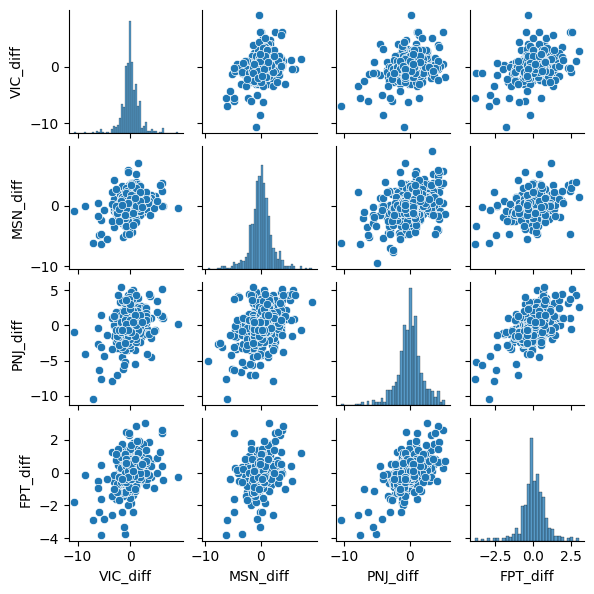

In [16]:
sns.pairplot(value_diff_open, height = 1.5)

In [17]:
#Different between 2 Close price
value_diff_close = pd.DataFrame()
value_diff_close['Date'] = date_df['Date']
for name in list_stocks_name:
  value_diff_close[name + '_diff'] = stocks_df_concat[name]['Close'].diff()
value_diff_close

,Date,VIC_diff,MSN_diff,PNJ_diff,FPT_diff
0,2017-12-25,NaN,NaN,NaN,NaN
1,2017-12-26,NaN,1.3,NaN,NaN
2,2017-12-27,NaN,-0.5,NaN,NaN
3,2017-12-28,NaN,0.7,NaN,NaN
4,2017-12-29,NaN,1.0,NaN,NaN
...,...,...,...,...,...
743,2020-12-16,0.0,0.0,0.5,0.4
744,2020-12-17,-2.3,0.5,-1.8,-0.6
745,2020-12-18,0.0,0.1,1.5,0.4
746,2020-12-21,1.7,-0.3,0.0,0.6


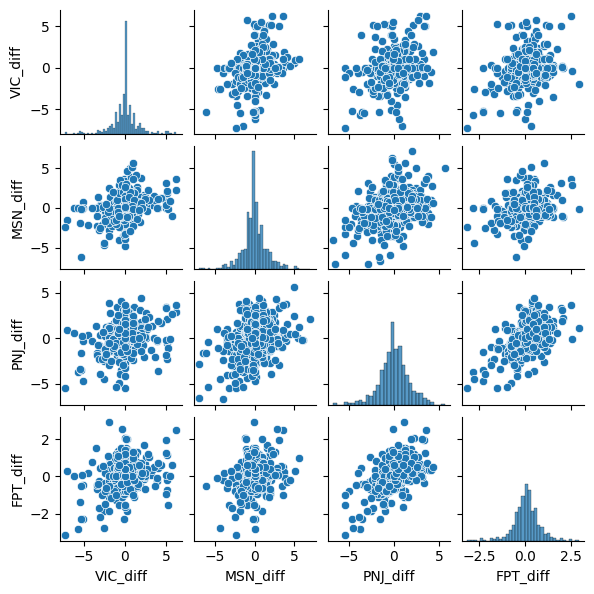

In [18]:
sns.pairplot(value_diff_close, height = 1.5)

In [19]:
#Different between 2 High price
value_diff_high = pd.DataFrame()
value_diff_high['Date'] = date_df['Date']
for name in list_stocks_name:
  value_diff_high[name + '_diff'] = stocks_df_concat[name]['High'].diff()
value_diff_high

,Date,VIC_diff,MSN_diff,PNJ_diff,FPT_diff
0,2017-12-25,NaN,NaN,NaN,NaN
1,2017-12-26,NaN,0.1,NaN,NaN
2,2017-12-27,NaN,0.2,NaN,NaN
3,2017-12-28,NaN,0.3,NaN,NaN
4,2017-12-29,NaN,1.0,NaN,NaN
...,...,...,...,...,...
743,2020-12-16,-1.8,-0.2,-1.4,0.0
744,2020-12-17,-0.2,0.7,-0.2,-0.5
745,2020-12-18,-0.8,0.0,0.1,0.0
746,2020-12-21,0.3,0.7,-0.1,0.8


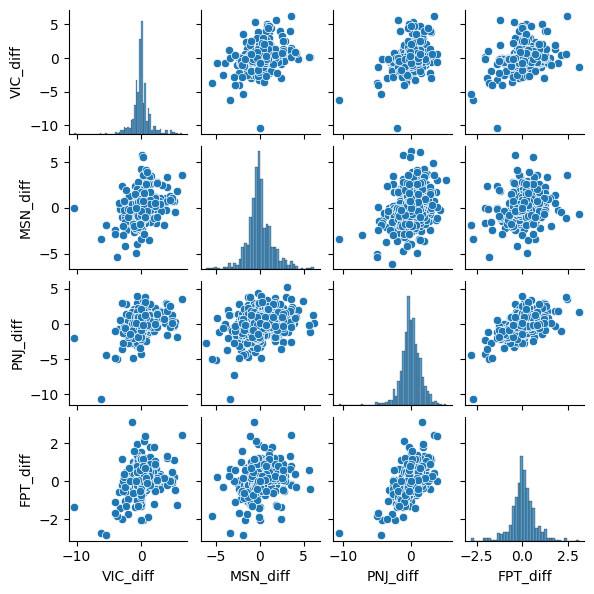

In [20]:
sns.pairplot(value_diff_high, height = 1.5)

In [21]:
#Different between 2 Low price
value_diff_low = pd.DataFrame()
value_diff_low['Date'] = date_df['Date']
for name in list_stocks_name:
  value_diff_low[name + '_diff'] = stocks_df_concat[name]['Low'].diff()
value_diff_low

,Date,VIC_diff,MSN_diff,PNJ_diff,FPT_diff
0,2017-12-25,NaN,NaN,NaN,NaN
1,2017-12-26,NaN,1.30,NaN,NaN
2,2017-12-27,NaN,0.50,NaN,NaN
3,2017-12-28,NaN,-0.30,NaN,NaN
4,2017-12-29,NaN,1.50,NaN,NaN
...,...,...,...,...,...
743,2020-12-16,-0.9,0.00,0.8,0.4
744,2020-12-17,-1.2,-0.01,-2.0,-1.0
745,2020-12-18,-0.2,0.80,0.8,0.5
746,2020-12-21,0.4,-0.30,0.7,0.6


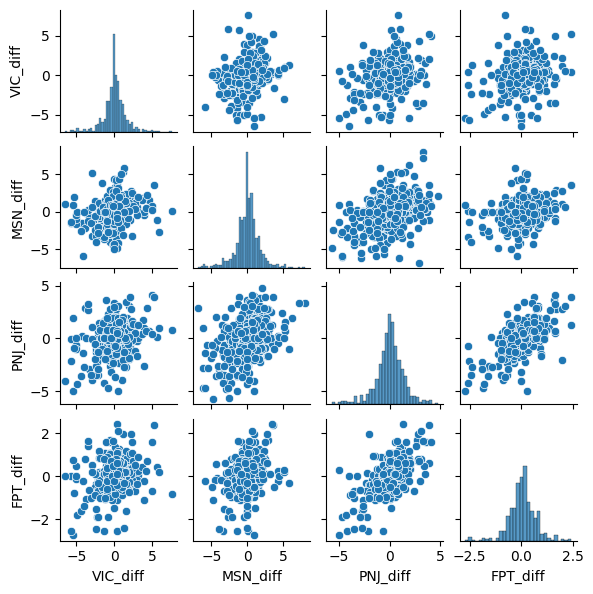

In [22]:
sns.pairplot(value_diff_low, height = 1.5)

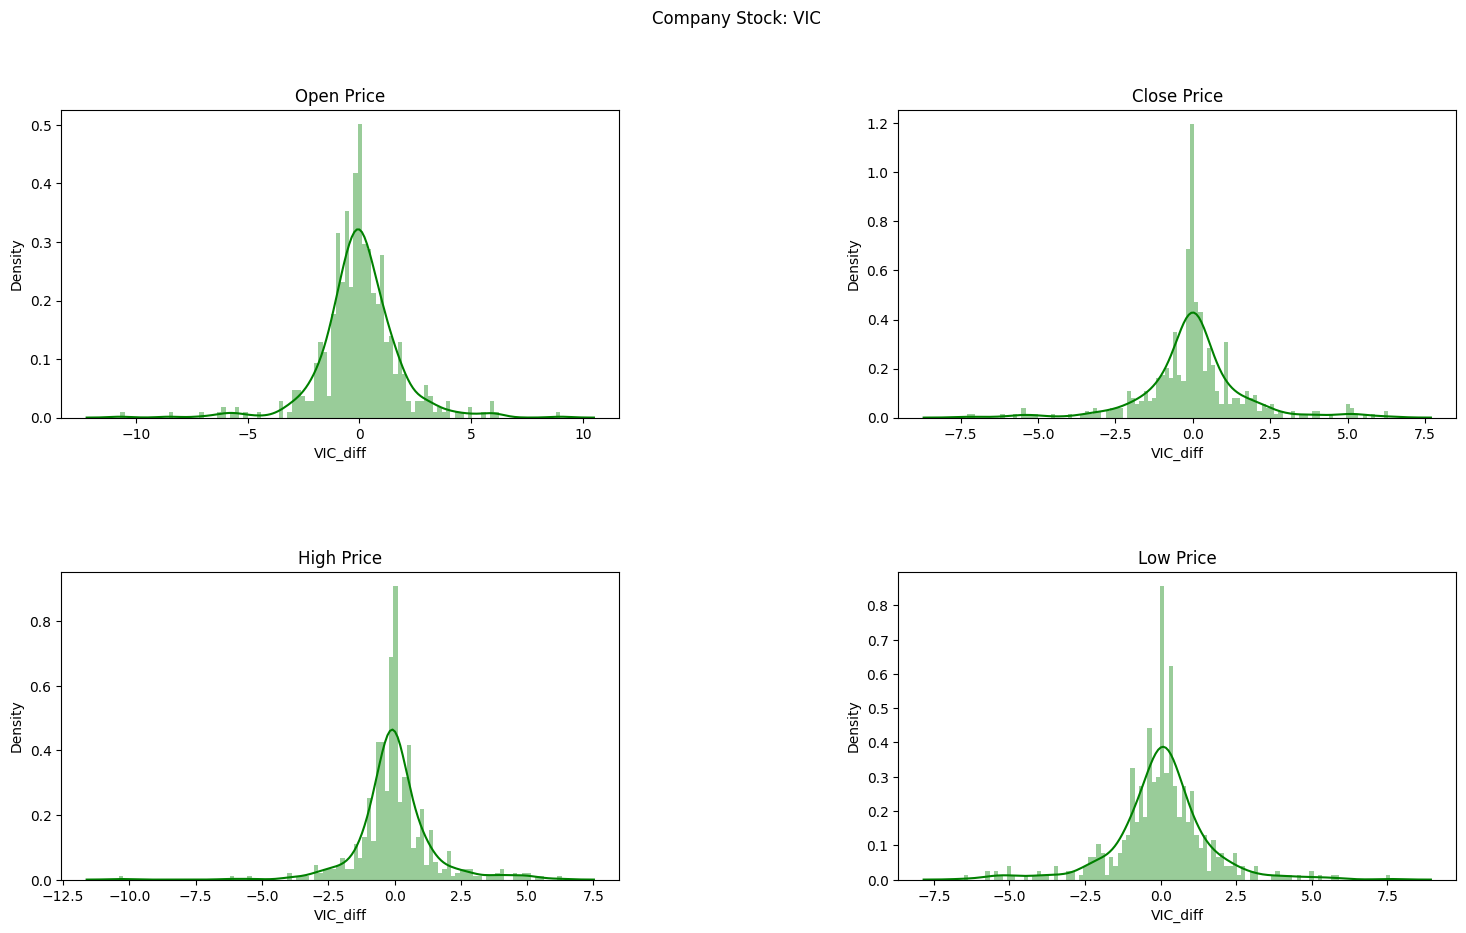

In [23]:
#Stock price distribution: VIC
distplot_chart('VIC_diff')

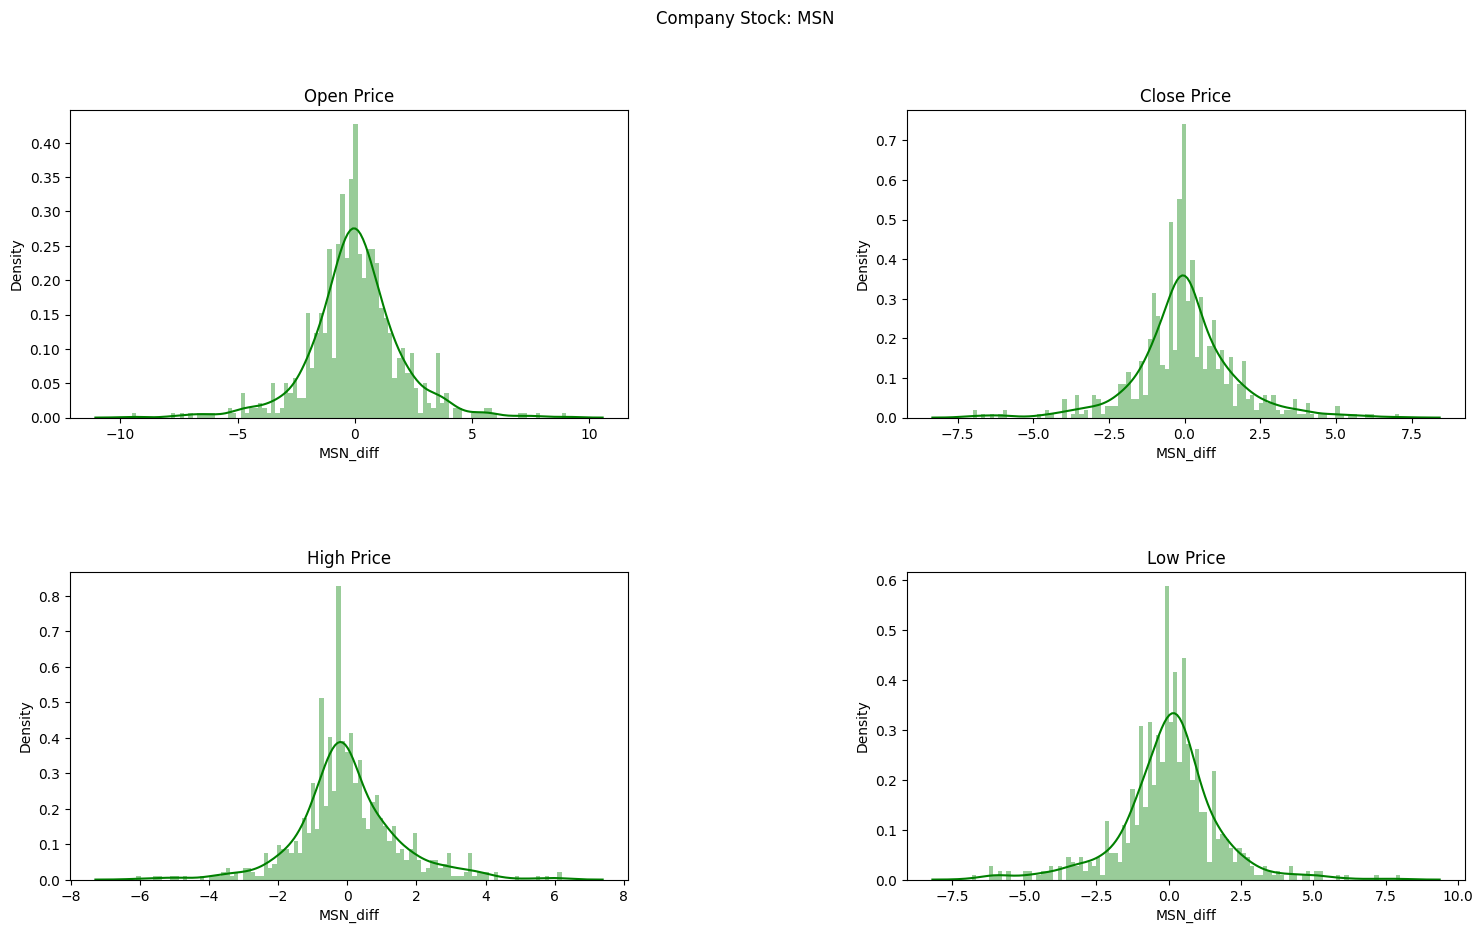

In [24]:
#Stock price distribution: MSN
distplot_chart('MSN_diff')

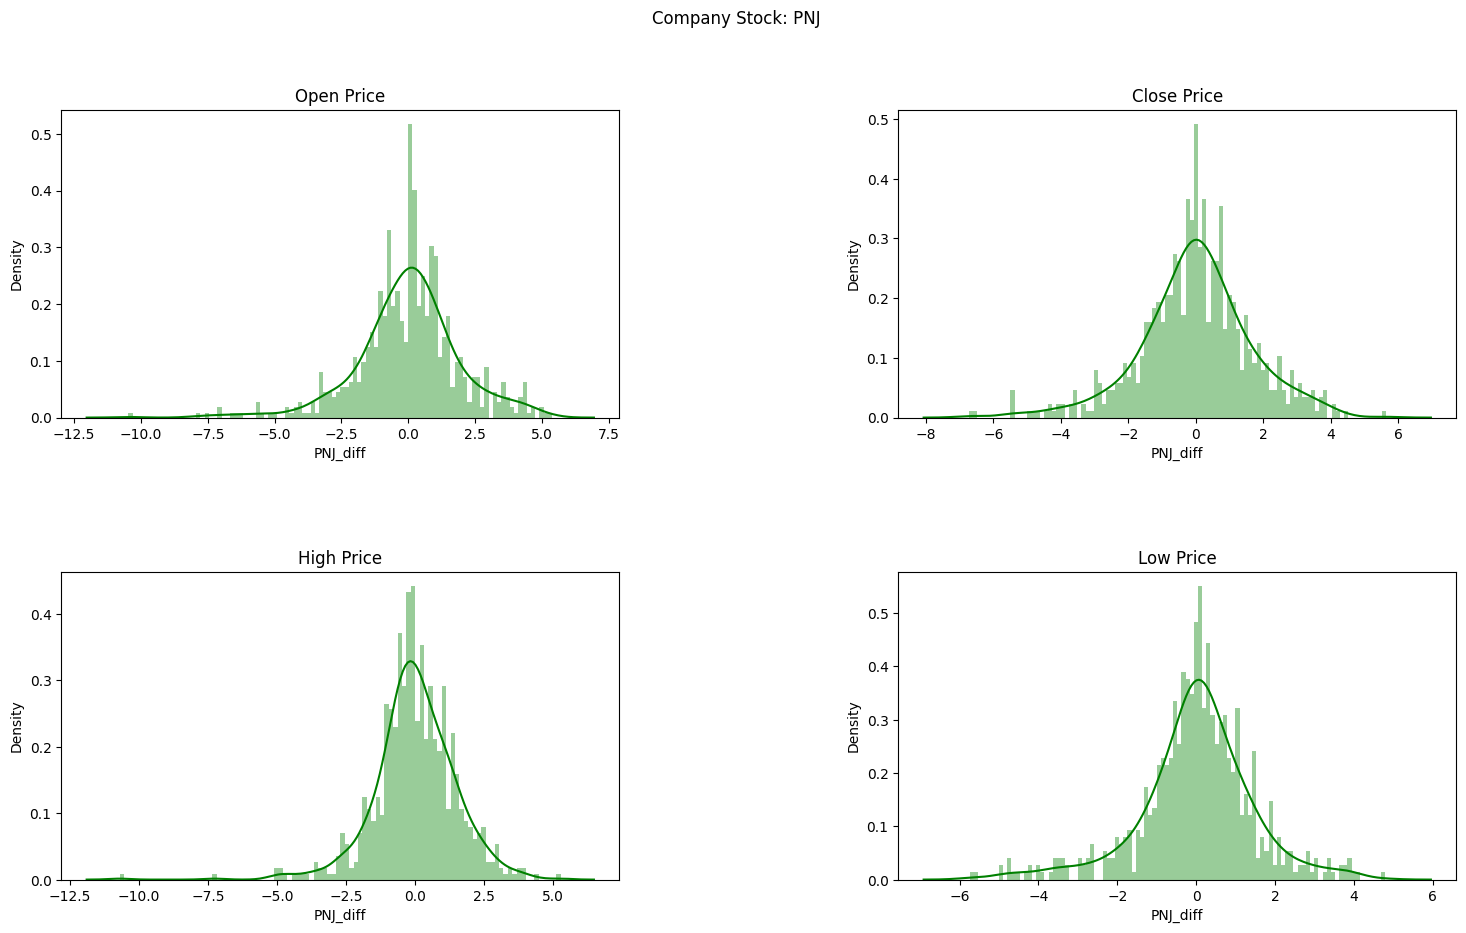

In [25]:
#Stock price distribution: PNJ
distplot_chart('PNJ_diff')

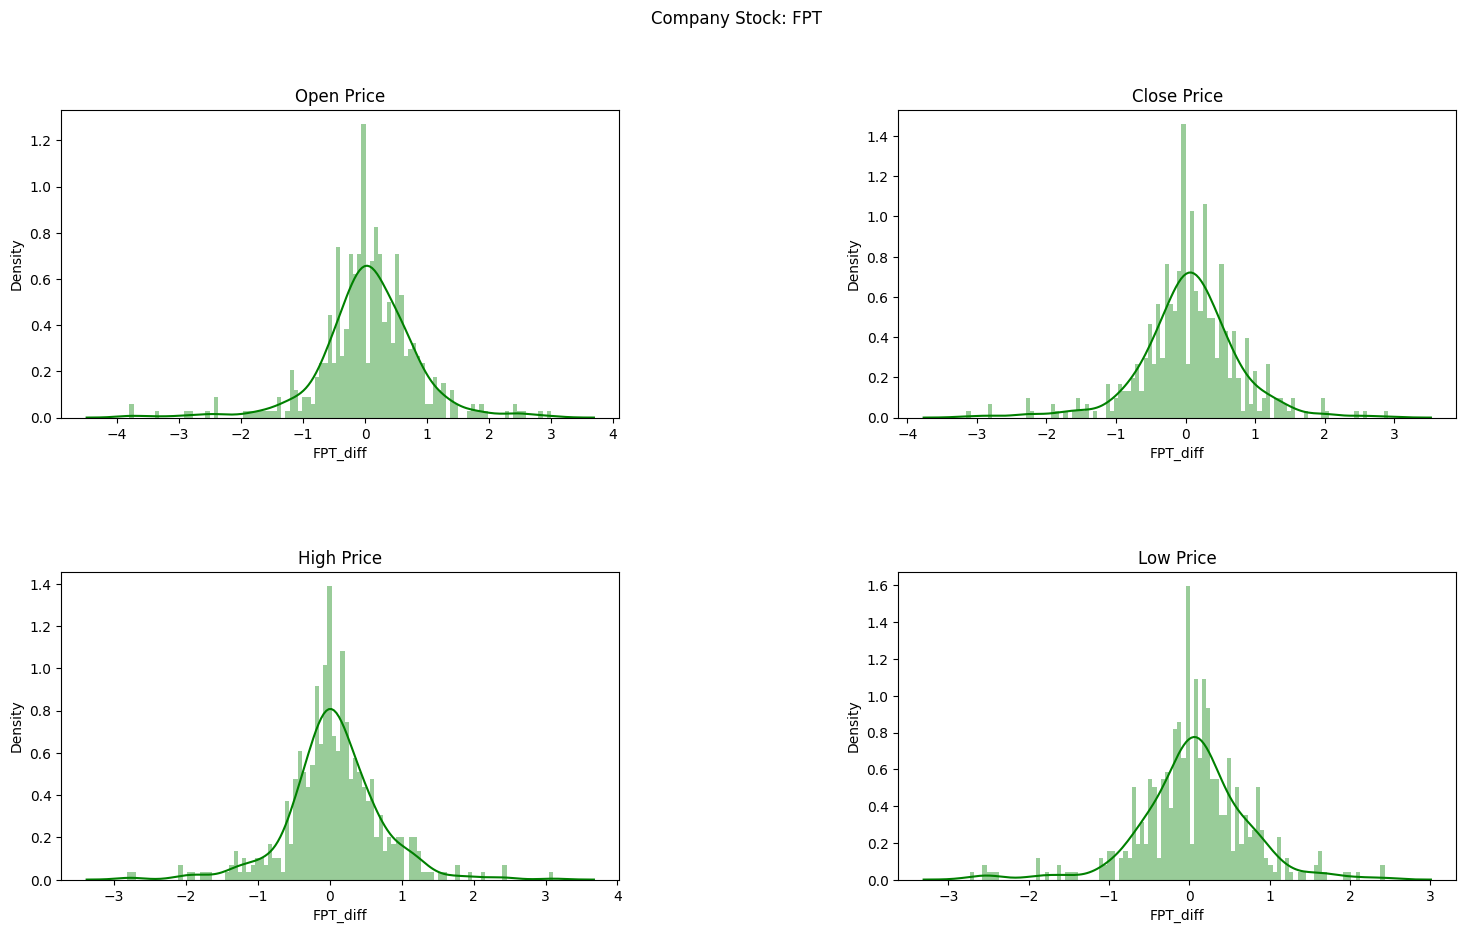

In [26]:
#Stock price distribution: FPT
distplot_chart('FPT_diff')

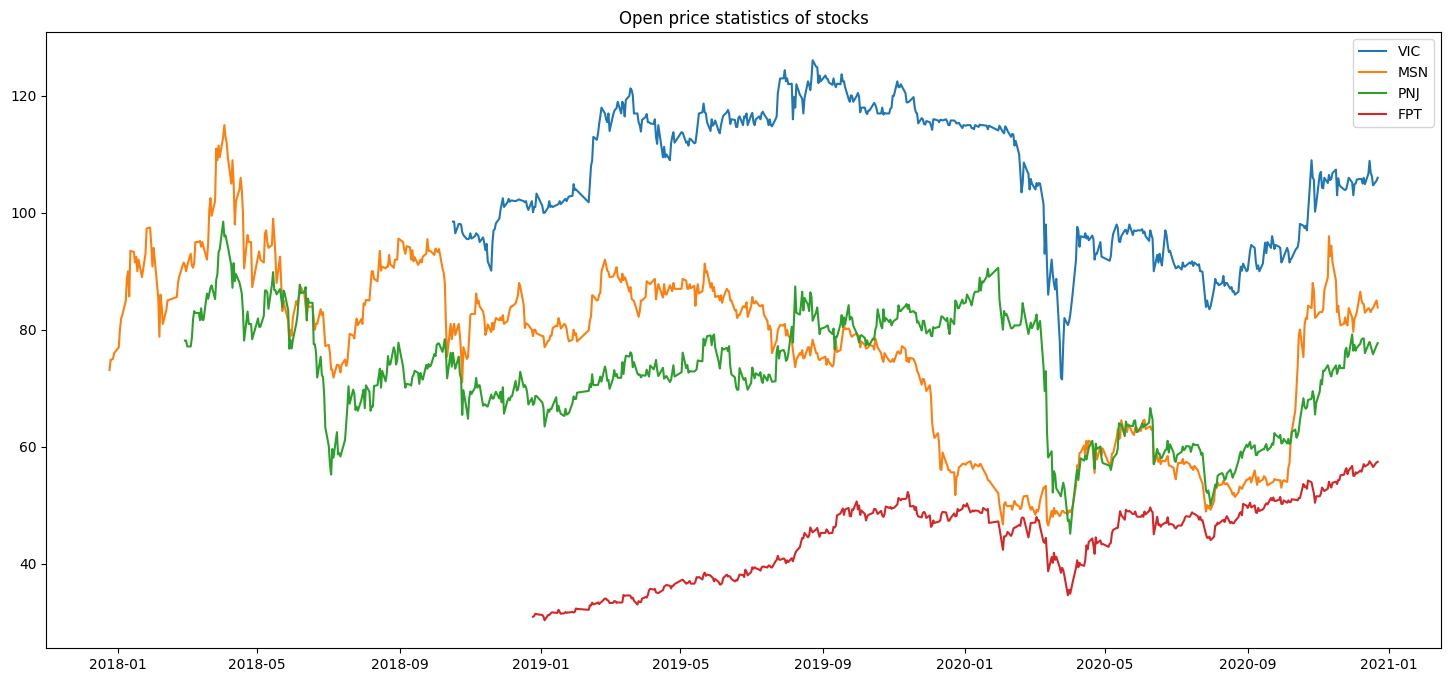

In [27]:
#Open price statistics of stocks
plt.figure(figsize=(18, 8))
for name in list_stocks_name:
  plt.plot(stocks_df_concat[name]['Date'], stocks_df_concat[name]['Open'], label = name)
plt.title("Open price statistics of stocks")
plt.legend()

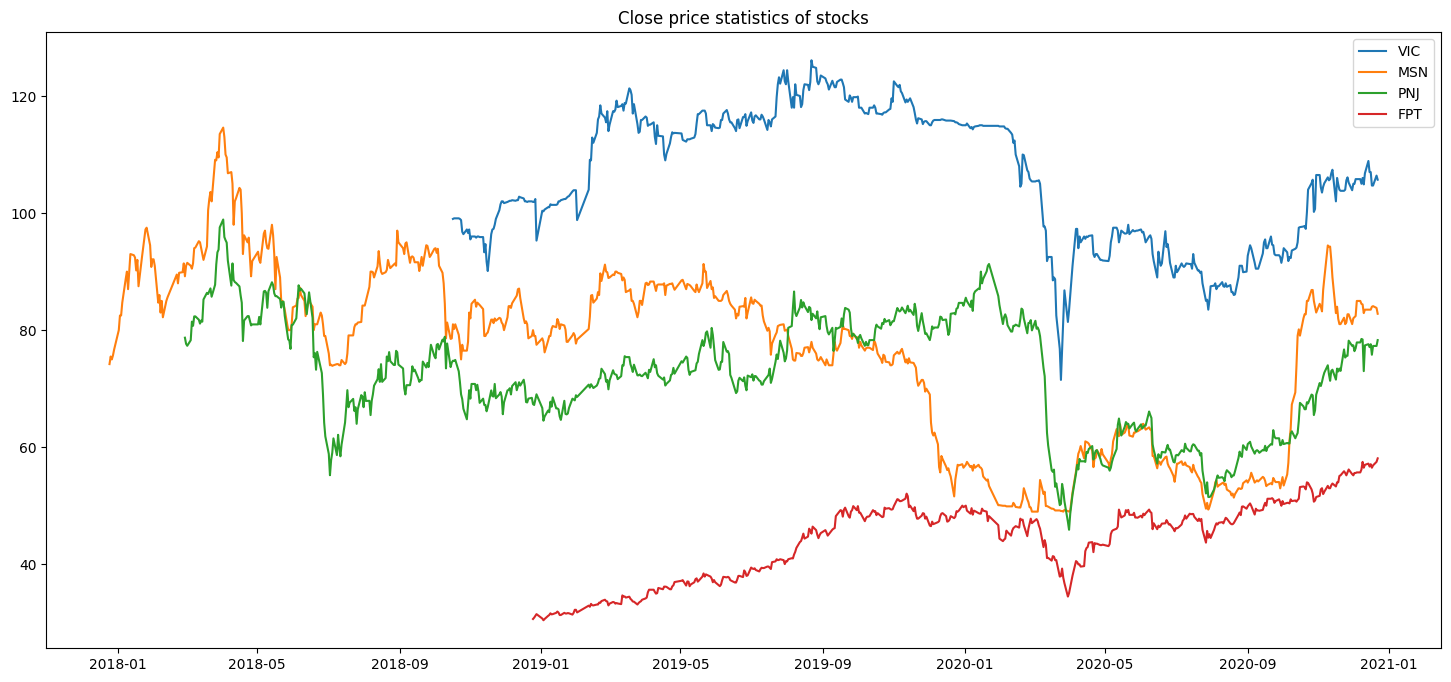

In [28]:
#Close price statistics of stocks
plt.figure(figsize=(18, 8))
for name in list_stocks_name:
  plt.plot(stocks_df_concat[name]['Date'], stocks_df_concat[name]['Close'], label = name)
plt.title("Close price statistics of stocks")
plt.legend()

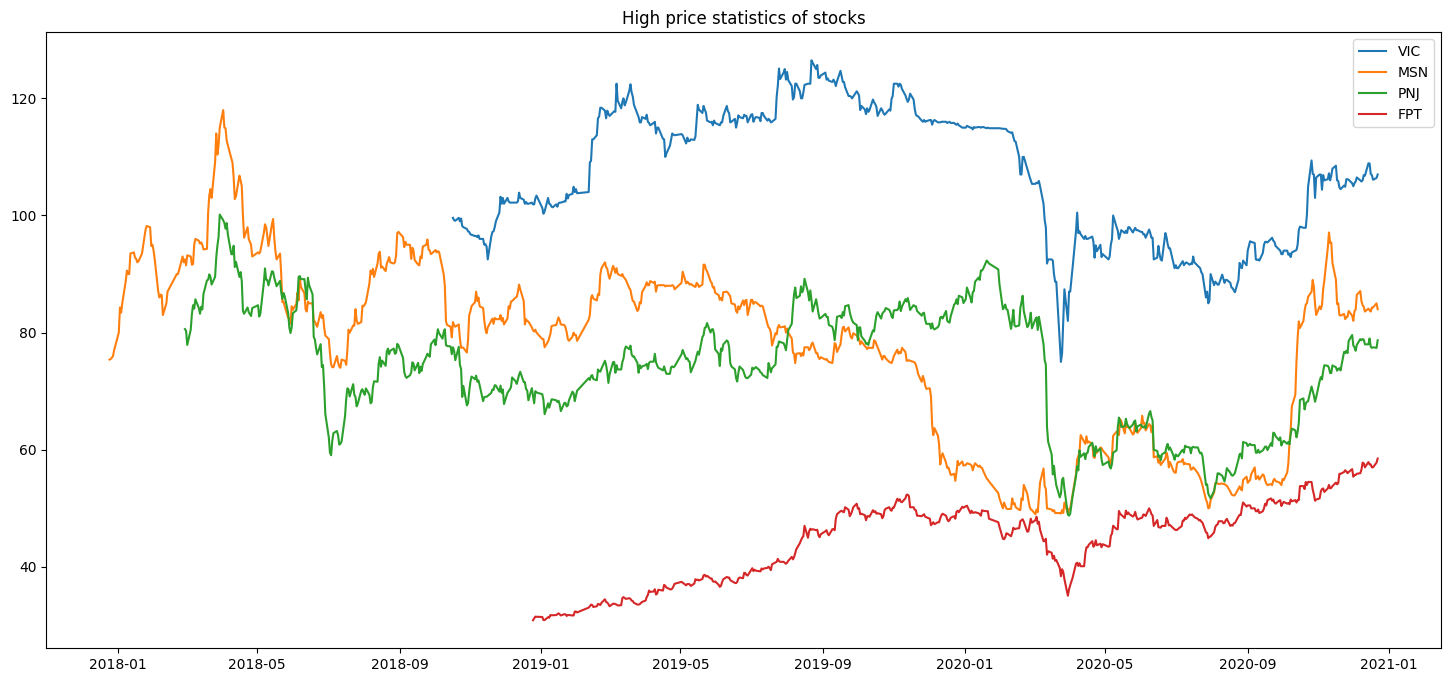

In [29]:
#High price statistics of stocks
plt.figure(figsize=(18, 8))
for name in list_stocks_name:
  plt.plot(stocks_df_concat[name]['Date'], stocks_df_concat[name]['High'], label = name)
plt.title("High price statistics of stocks")
plt.legend()

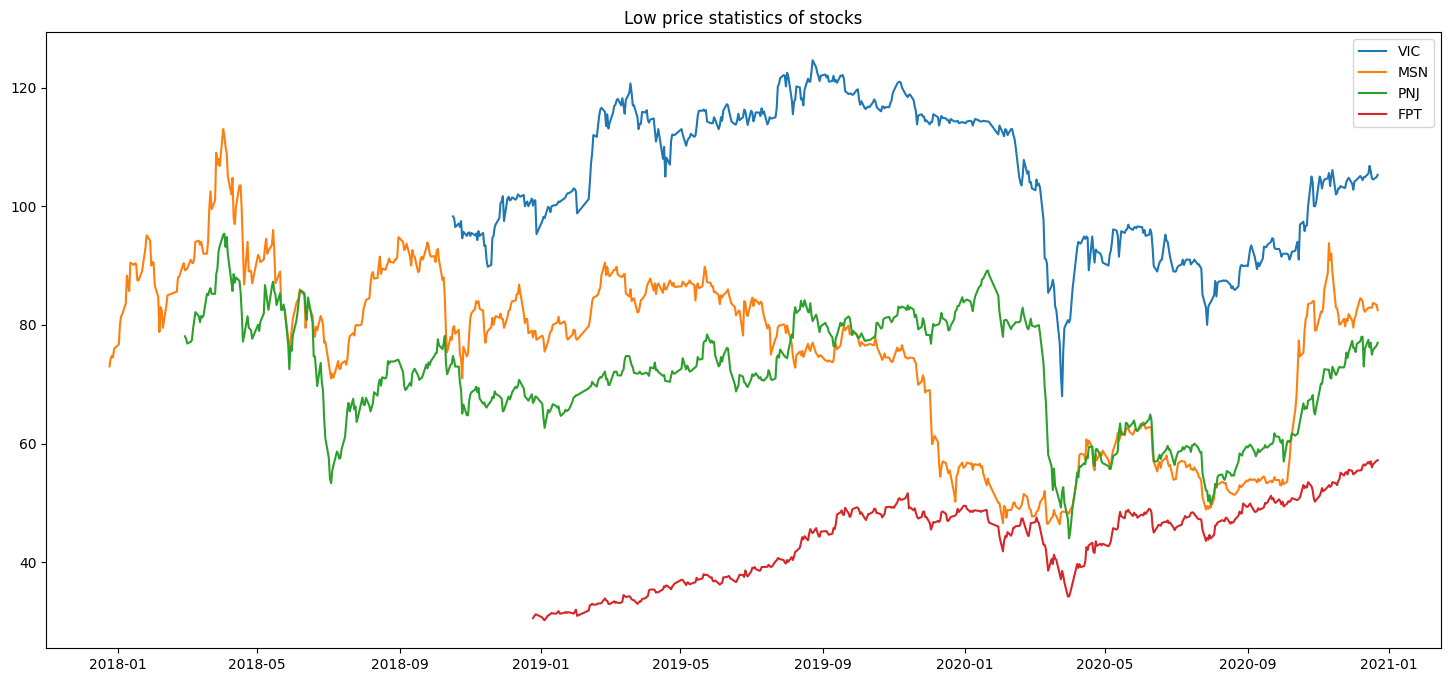

In [30]:
#Low price statistics of stocks
plt.figure(figsize=(18, 8))
for name in list_stocks_name:
  plt.plot(stocks_df_concat[name]['Date'], stocks_df_concat[name]['Low'], label = name)
plt.title("Low price statistics of stocks")
plt.legend()

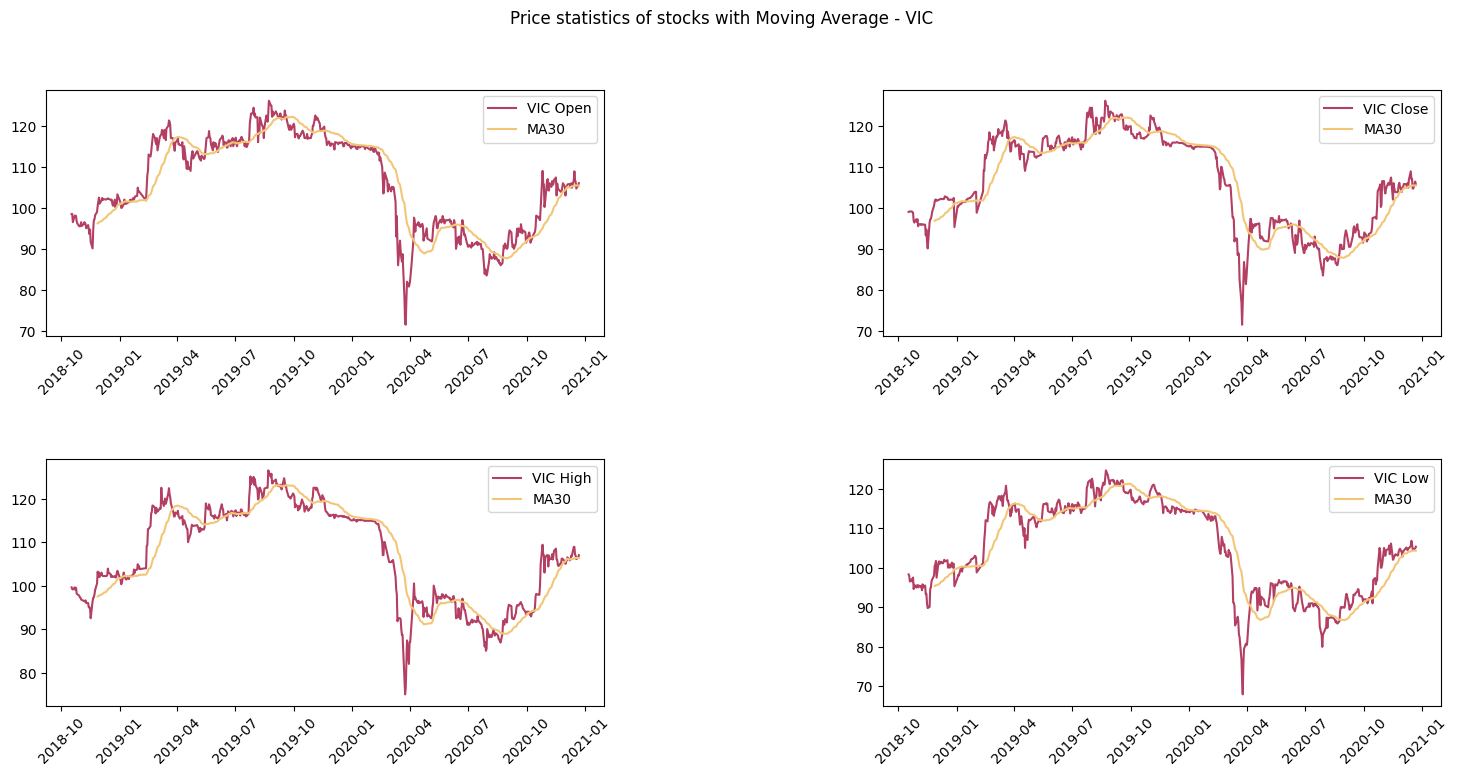

In [31]:
#Price statistics of stocks with Moving Average - VIC
line_chart(df_vic_pivot)

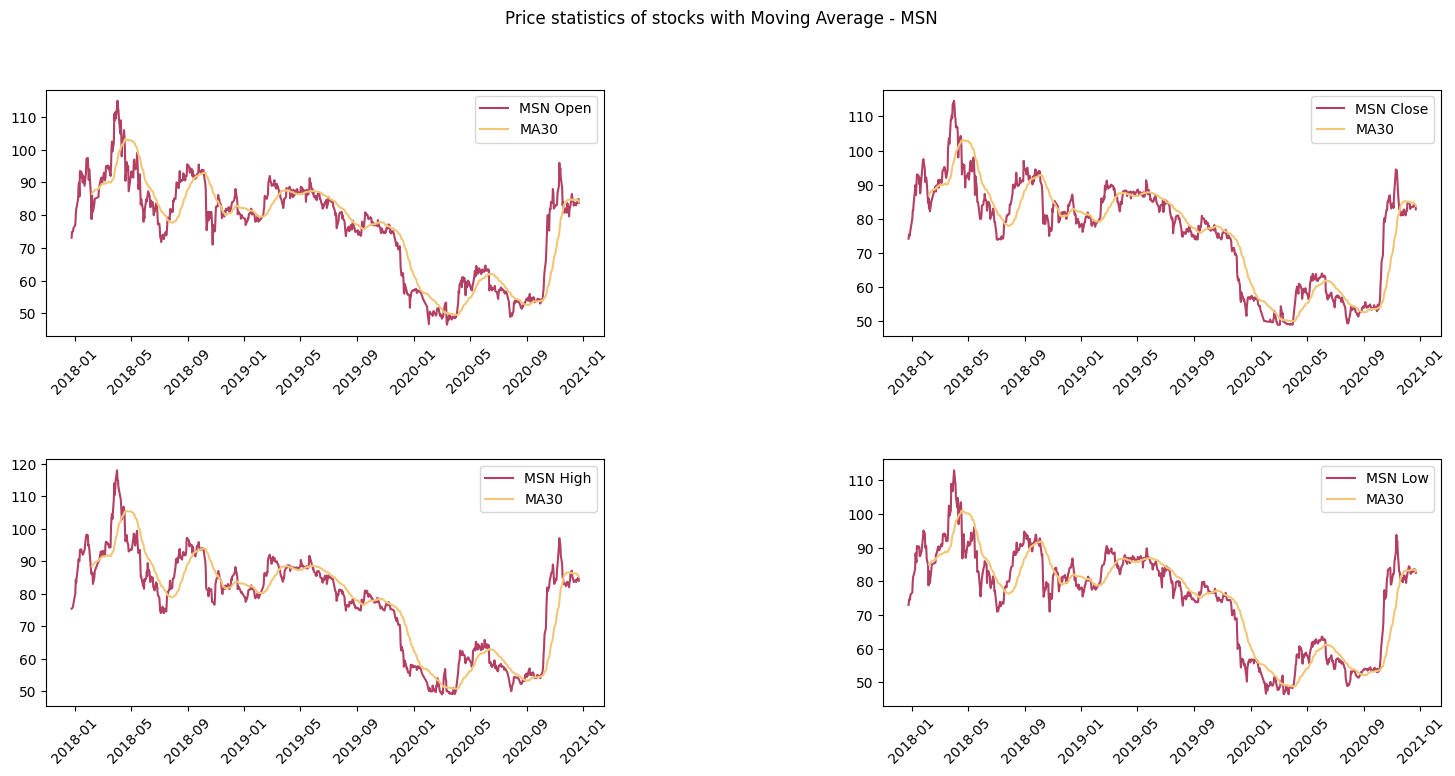

In [32]:
#Price statistics of stocks with Moving Average - MSN
line_chart(df_msn_pivot)

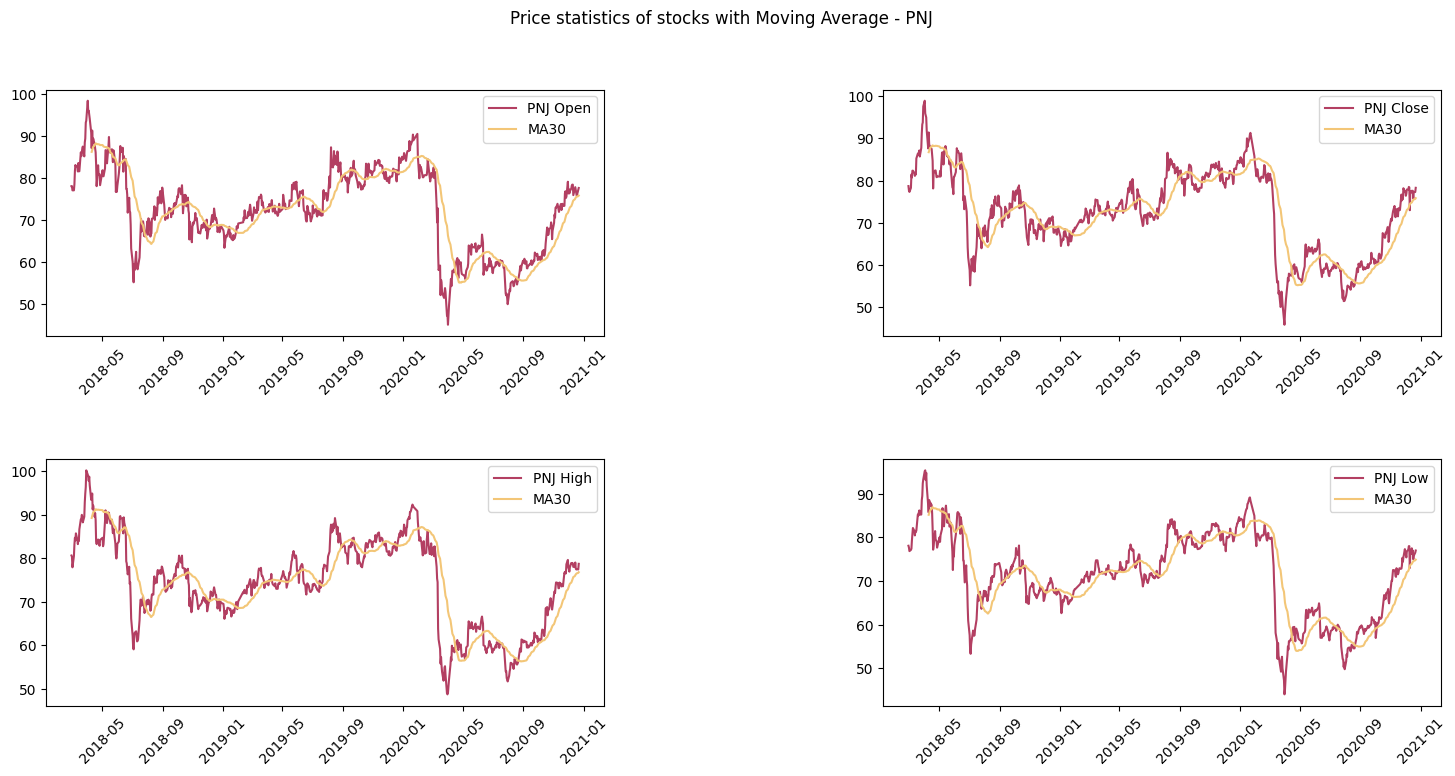

In [33]:
#Price statistics of stocks with Moving Average - PNJ
line_chart(df_pnj_pivot)

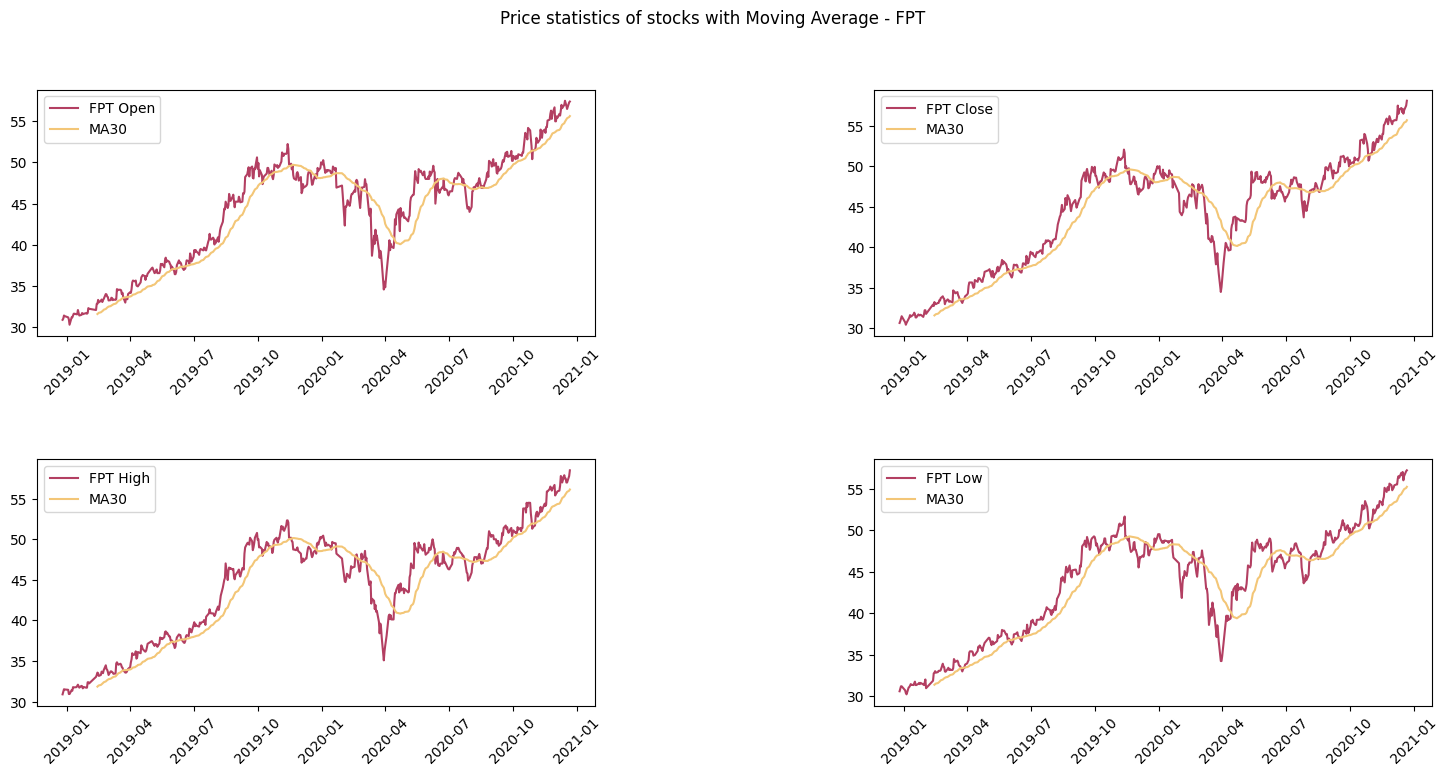

In [34]:
#Price statistics of stocks with Moving Average - FPT
line_chart(df_fpt_pivot)

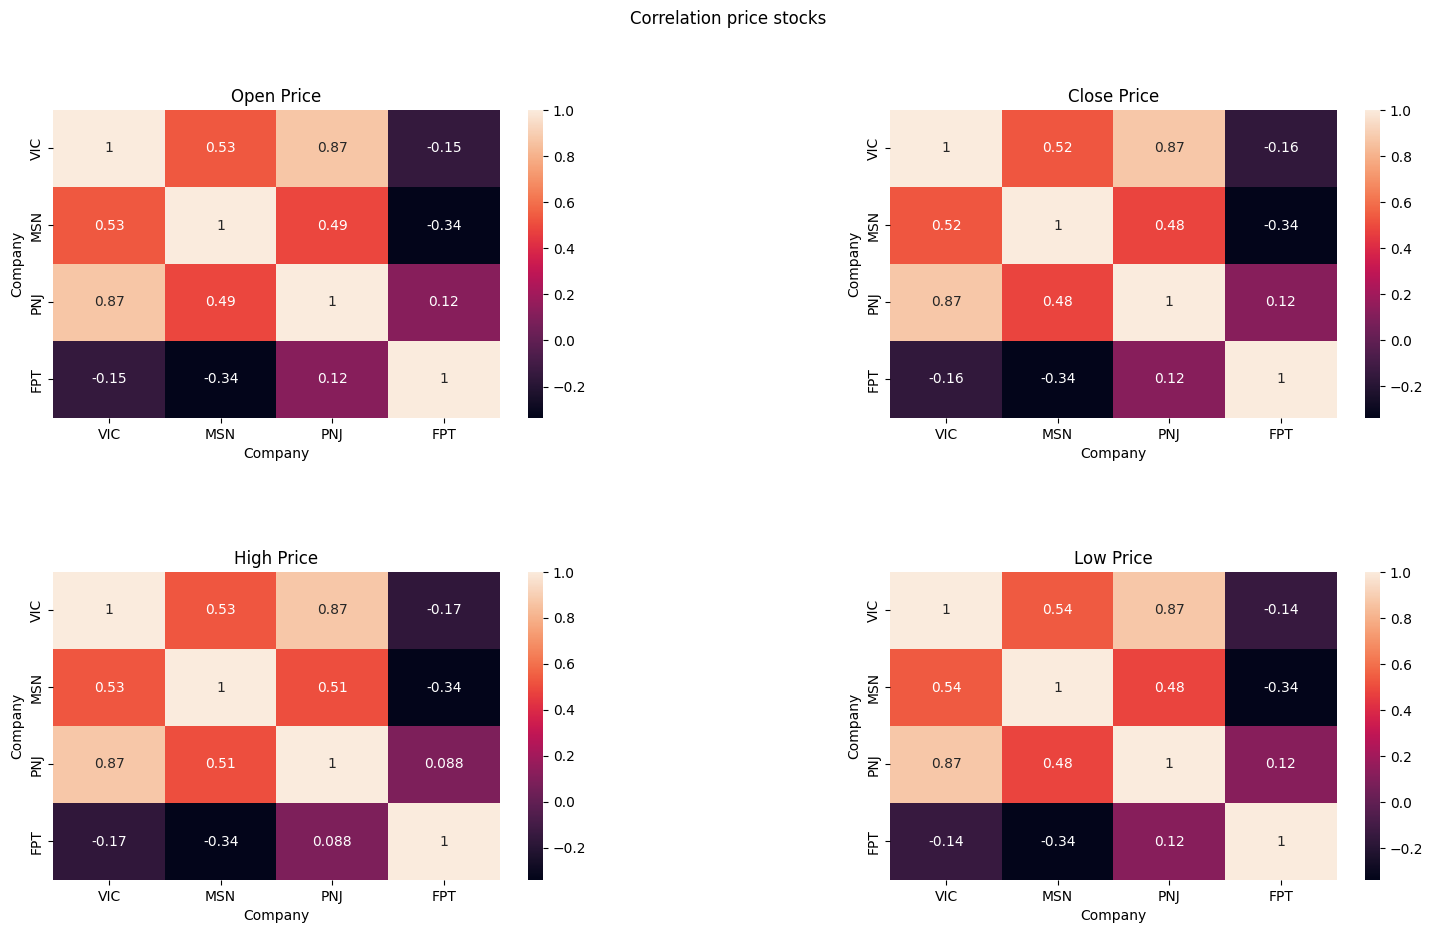

In [35]:
#Correlation price stocks
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

#Open price
ax = fig.add_subplot(2, 2, 1)
sns.heatmap(stocks_df_concat.xs(key = "Open", axis = 1, level = 'Info').corr(), annot = True).set(title='Open Price')

#Close price
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(stocks_df_concat.xs(key = "Close", axis = 1, level = 'Info').corr(), annot = True).set(title='Close Price')

#High price
ax = fig.add_subplot(2, 2, 3)
sns.heatmap(stocks_df_concat.xs(key = "High", axis = 1, level = 'Info').corr(), annot = True).set(title='High Price')

#Low price
ax = fig.add_subplot(2, 2, 4)
sns.heatmap(stocks_df_concat.xs(key = "Low", axis = 1, level = 'Info').corr(), annot = True).set(title='Low Price')

plt.suptitle("Correlation price stocks")
plt.show()


In [36]:
#Candlestick Chart VIC
candlestick_chart(df_vic_pivot)

In [37]:
#Candlestick Chart MSN
candlestick_chart(df_msn_pivot)

In [38]:
#Candlestick Chart PNJ
candlestick_chart(df_pnj_pivot)

In [39]:
#Candlestick Chart FPT
candlestick_chart(df_fpt_pivot)

<h1>Model<h1>

In [40]:
#LinearRegression
def model_LinearRegression(df):
  df_tmp = df.dropna()
  data = df_tmp[['Date','Open', 'High', 'Low', 'Close', 'Volume']]

  #split data to train and test
  tscv = TimeSeriesSplit(n_splits = 2, test_size = None)
  for train_index, test_index in tscv.split(data):
    data_train, data_test = data.iloc[train_index], data.iloc[test_index]

  x_train = data_train.drop(columns = ['Date','Close'])
  y_train = np.array(data_train['Close'])
  x_test = data_test.drop(columns = ['Date','Close'])
  y_test = np.array(data_test['Close'])

  #train model
  model = LinearRegression()
  model.fit(x_train, y_train)
  print("R Squared: ", model.score(x_test, y_test))
  y_predict = model.predict(x_test)

  # visualize_chart_stock_price_volatility
  data_test['Prediction'] = y_predict
  data_test['Close_diff'] = data_test['Close'].diff()
  data_test['Prediction_diff'] = data_test['Prediction'].diff()

  plt.figure(figsize=(20,8))
  data_test['Predictions'] = y_predict
  plt.plot(data_train['Date'], data_train['Close'].diff())
  plt.plot(data_test['Date'], data_test[['Close_diff', 'Prediction_diff']])
  plt.legend(['Train', 'Close', 'Prediction'], loc = 'lower right')


R Squared:  0.9722281258921176


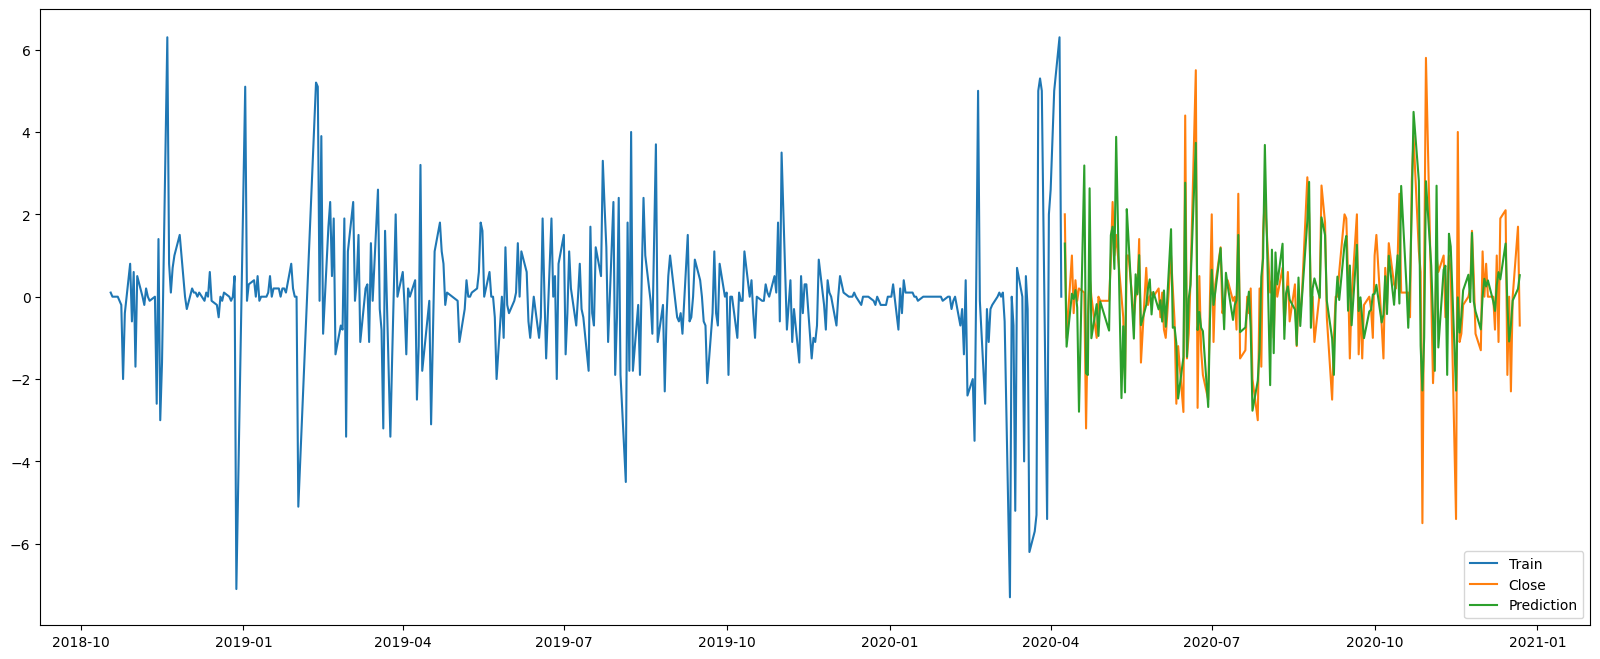

In [41]:
model_LinearRegression(df_vic_pivot)

R Squared:  0.9960518131028696


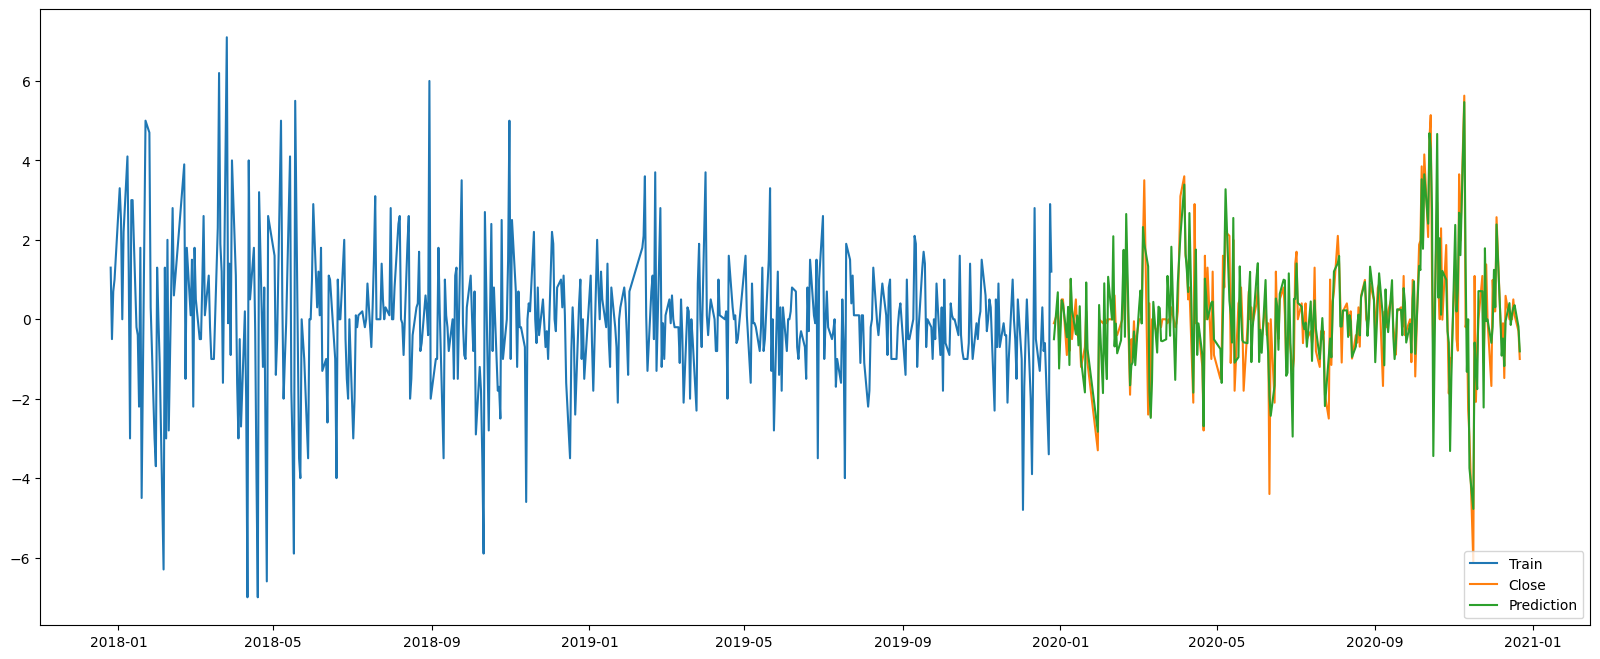

In [42]:
model_LinearRegression(df_msn_pivot)

R Squared:  0.9953572465489088


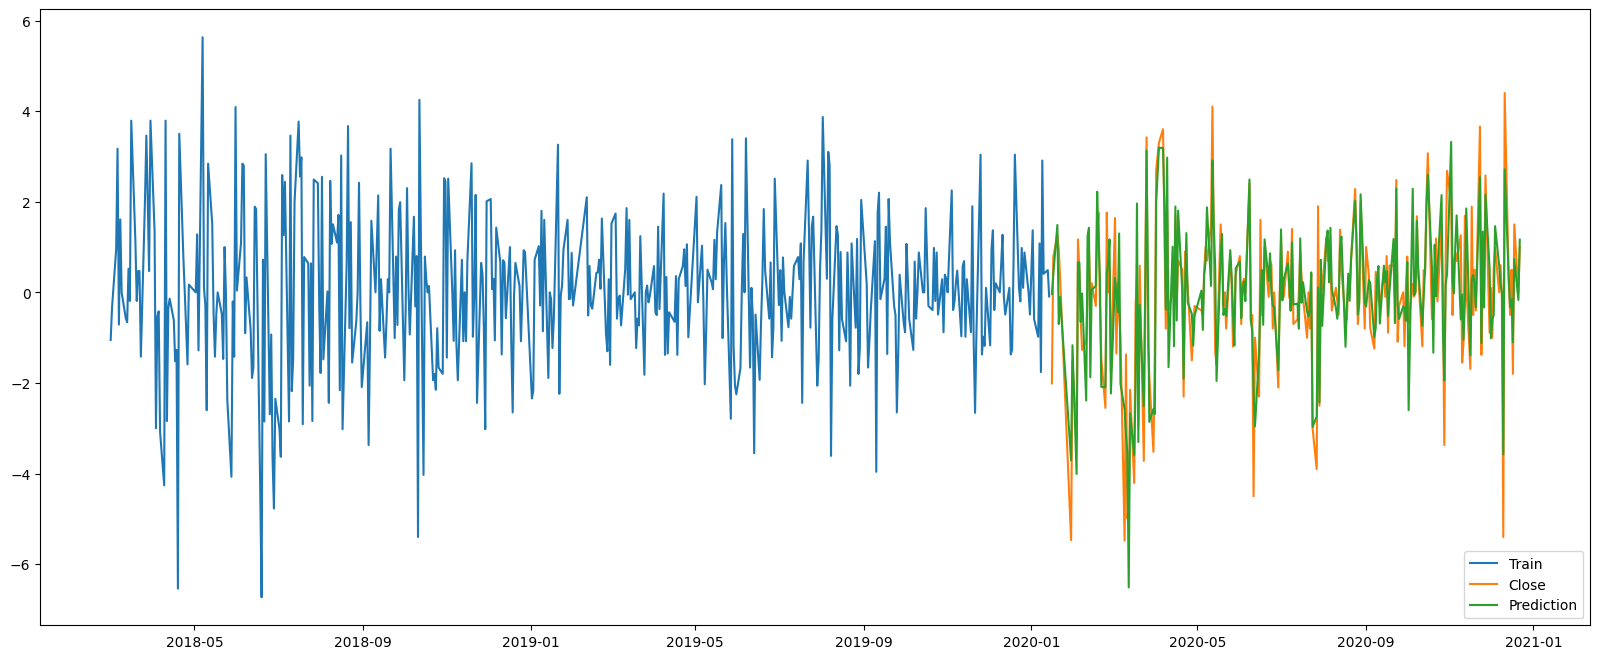

In [43]:
model_LinearRegression(df_pnj_pivot)

R Squared:  0.9928469914938725


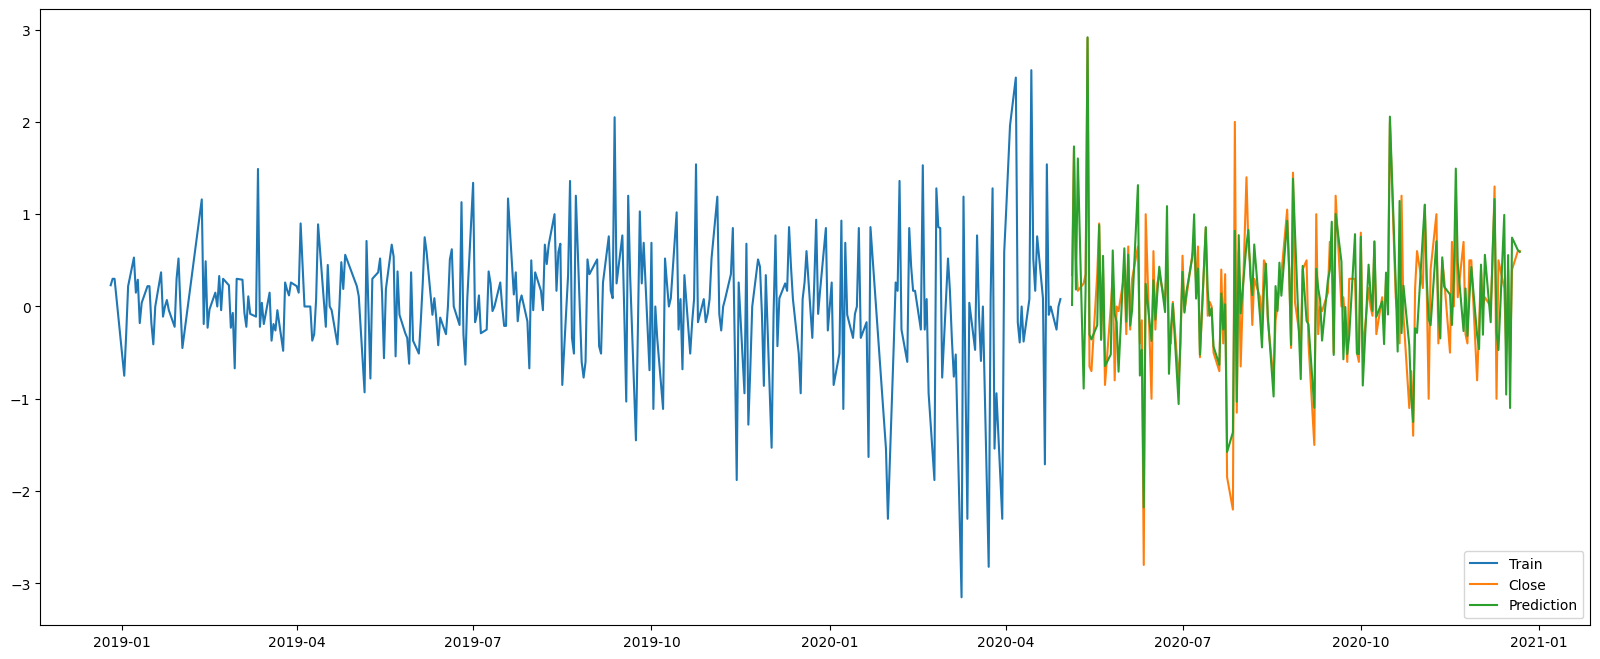

In [44]:
model_LinearRegression(df_fpt_pivot)